In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import jax
import znnl
from neural_tangents import stax
import copy
import optax

from flax import linen as nn
import flax
import jax.nn.initializers as inits

import matplotlib.pyplot as plt

import numpy as onp
import jax.numpy as np
# import time
import copy

2023-09-23 19:12:38.798831: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-09-23 19:12:44.592049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using backend: cpu

Available hardware:

TFRT_CPU_0

# Including the trace regularization

In [2]:
from flax.training.train_state import TrainState
from znnl.training_strategies import SimpleTraining
from typing import Callable, List, Optional, Tuple, Union
from znnl.accuracy_functions.accuracy_function import AccuracyFunction
from znnl.models.jax_model import JaxModel
from znnl.training_strategies.recursive_mode import RecursiveMode

In [58]:
# def fun(a, params):
#     return jax.tree_util.tree_map(lambda x: x + a, params)

# params = model.model_state.params
# p = jax.vmap(fun, in_axes=(0, None))(np.arange(4), params)
# res = jax.vmap(model.apply, in_axes=(0, None))(p, data_generator.train_ds['inputs'][:10])
# # jax.tree_util.tree_map(lambda x: x.shape, p)
# np.shape(res)

In [31]:
# def _create_noise(params: dict, key):
#         """
#         Create a perturbation for the parameters.

#         Parameters
#         ----------
#         params : dict
#                 Parameters of the model.

#         Returns
#         -------
#         perturbation : dict
#                 Perturbation of the parameters.
#         """
#         noise = jax.tree_util.tree_map(lambda x: 0.1 * jax.random.normal(key, x.shape), params)
#         return noise


# def pert_apply(params, key):
#     """
#     helper grad computation

#     Returns
#     -------
#     ntk_trace_values : float, shape=(batch_size,)
#             Model predictions, averaged over the output dimension.
#     """
#     noise = _create_noise(params, key)
#     perturbed_params = jax.tree_util.tree_map(lambda x, y: x + y, params, noise)
#     perturbed_predictions = model.apply(perturbed_params, data_generator.train_ds["inputs"][:10])
#     return perturbed_predictions


# params = model.model_state.params
# keys = jax.random.split(jax.random.PRNGKey(0), num=8)
# # keys = np.arange(4)#[:, None]
# pred = jax.vmap(pert_apply, in_axes=(None, 0))(params, keys)
# np.shape(pred)

## Raw code

In [95]:
class BlurredTraining(SimpleTraining):

    def __init__(
        self,
        model: Union[JaxModel, None],
        loss_fn: Callable,
        accuracy_fn: AccuracyFunction = None,
        seed: int = None,
        recursive_mode: RecursiveMode = None,
        disable_loading_bar: bool = False,
        recorders: List["JaxRecorder"] = None,
        blurr_radius: float = 1e-5, 
        integral_numbers: int = 10,
    ):
        """
        Construct a blurred training strategy for a model.

        The training is performed using a method to blurr the loss surface.

        Parameters
        ----------
        model : Union[JaxModel, None]
                Model class for a Jax model.
                "None" is only used if the training strategy is passed as an input
                to a bigger framework. The strategy then is applied to the framework
                and the model instantiation is handled by that framework.
        loss_fn : Callable
                A function to use in the loss computation.
        accuracy_fn : AccuracyFunction (default = None)
                Funktion class for computing the accuracy of model and given data.
        seed : int (default = None)
                Random seed for the RNG. Uses a random int if not specified.
        recursive_mode : RecursiveMode
                Defining the recursive mode that can be used in training.
                If the recursive mode is used, the training will be performed until a
                condition is fulfilled.
        disable_loading_bar : bool
                Disable the output visualization of the loading bar.
        recorders : List[JaxRecorder]
                A list of recorders to monitor model training.
        blurr_radios : float
                The blurr radius to use in the training.
        integral_numbers : int
                The number of random points to approximate the blurr integral.
        """
        super().__init__(
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            seed=seed,
            recursive_mode=recursive_mode,
            disable_loading_bar=disable_loading_bar,
            recorders=recorders,
        )
        self.blurr_radius = blurr_radius
        self.integral_numbers = integral_numbers

    def _create_noise(self, params: dict, key, std: float):
        """
        Create noise for the parameters of the model. 

        Create Gaussian noise of Euclidean norm sampled from the the distribution:
        N(0, std)

        Parameters
        ----------
        params : dict
                Parameters of the model.
        key : jax.random.PRNGKey
                Key to sample the noise. 

        Returns
        -------
        noise : dict
                Noise dict of similar shape as the model parameters. 
        """

        noise = jax.tree_util.tree_map(lambda x: jax.random.normal(key, x.shape) * std * self.blurr_radius, params) 
        return noise

    def _calculate_weighting_factor(self, noise_magnitude: float):
        """
        Calculate the weight factor corresponding to the applied noise. 

        Parameters
        ----------
        noise_magnitude : float
                Magnitude of the applied noise.

        Returns
        -------
        weight_factor : float
                Weight factor to apply to the loss function.
        """
        return np.exp(noise_magnitude ** 2 / 2 * self.blurr_radius ** 2)
    
                
    def _train_step(self, state: TrainState, batch: dict):
        """
        Train a single step.

        Parameters
        ----------
        state : TrainState
                Current state of the neural network.
        batch : dict
                Batch of data to train on.

        Returns
        -------
        state : dict
                Updated state of the neural network.
        metrics : dict
                Metrics for the current model.
        """
        
        def pert_apply(params, key, noise_magnitude):
            """
            Helper function to calculate a perturbed forward pass. 

            The computation is executed in the following steps:
            1. Create noise
            2. Add noise to parameters
            3. Evaluate the weight factor to apply to the loss
                The weight factor is applied to weight each perturbed prediction
                according to the magnitude of the noise.

            Parameters
            ----------
            params : dict
                    Parameters of the model.
            key : jax.random.PRNGKey
                    Key to sample the noise.

            Returns
            -------
            perturbed_predictions : float, shape=(batch_size, output_dim)
                     Perturbed model predictions.
            noise : dict
                     Noise applied to the parameters.
            """
            # Create noise 
            noise = self._create_noise(params, key, noise_magnitude)
            # Add noise to parameters to create perturbed parameters
            perturbed_params = jax.tree_util.tree_map(lambda x, y: x + y, params, noise)
            # Evaluate perturbed predictions
            perturbed_predictions = self.model.apply(perturbed_params, batch["inputs"])
        #     # Evaluate weight factor to scale the loss
        #     weight_factor = self._calculate_weighting_factor(noise_magnitude)
            return perturbed_predictions, noise

        def loss_fn(params):
            """
            helper loss computation
            """
            # Split the random key to create different noise for each integral number
            keys = jax.random.split(self.rng(), self.integral_numbers)
            noise_magnitudes = jax.random.normal(self.rng(), shape=(self.integral_numbers, ))
        
            # Vmap the perturbed forward pass to create a batch of perturbed predictions
            pred, noise = jax.vmap(pert_apply, in_axes=(None, 0, 0))(params, keys, noise_magnitudes)

            # Compute the loss for each perturbed prediction
            losses = jax.vmap(self.loss_fn, in_axes=(0, None))(pred, batch["targets"])
            # Weight the losses according to the weight factors
            losses = losses * self._calculate_weighting_factor(noise_magnitudes)
            # Compute the mean loss and predictions
            predictions = np.mean(pred, axis=0)
            loss = np.mean(losses)
            return loss, predictions
        
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

        (_, predictions), grads = grad_fn(state.params)
        state = state.apply_gradients(grads=grads)  # in place state update.
        metrics = self._compute_metrics(
            predictions=predictions, targets=batch["targets"]
        )

        return state, metrics

## Code with Regularizer class

In [ ]:
from abc import ABC

In [ ]:
class Regularizer(ABC):
    """
    Parent class for all regularizers.
    """

    def __init__(self, reg_factor) -> None:
        """
        Constructor of the regularizer class.

        Parameters
        ----------
        reg_factor : float
                Regularization factor.
        """
        self.reg_factor = reg_factor
    
    def __call__(self, apply_fn, params, batch):
        """
        Call function of the regularizer class.

        Parameters
        ----------
        params : dict
                Parameters of the model.

        Returns
        -------
        reg_loss : float
                Regularization loss.
        """
        raise NotImplementedError
    

class TraceRegularizer(Regularizer):
    """
    Trace regularizer class.

    Regularizing gradient based learning with proportional to the trace of the NTK.
    As the trace of the NTK is calculated from the gradients of the model, the
    regularizer is implemented as a function of the gradients.
    """

    def __init__(self, reg_factor) -> None:
        super().__init__(reg_factor)    
    
    def __call__(self, apply_fn, params, batch):
        """
        Call function of the trace regularizer class.

        Parameters
        ----------
        grads : dict
                Gradients of the model.

        Returns
        -------
        reg_loss : float
                Regularization loss.
        """

        def grad_helper_fn(params):
            """
            helper grad computation

            Returns
            -------
            ntk_trace_values : float, shape=(batch_size,)
                    Model predictions, averaged over the output dimension.
            """
            traced_predictions = apply_fn(params, batch["inputs"])
            return traced_predictions  

        # Compute gradient of shape=(batch_size, n_outputs, params)
        grad = jax.jacrev(grad_helper_fn)(params)
        # Compute squared gradient of shape=(batch_size, n_outputs, params)
        grad_square = jax.tree_util.tree_map(lambda x: x ** 2, grad)
        # Average over all axes except the batch axis.
        idx_tree = jax.tree_util.tree_map(lambda x: tuple(range(1, len(x.shape))), grad_square)
        grad_sum = jax.tree_util.tree_map(lambda x, y: np.mean(x, axis=y), grad_square, idx_tree)
        # Add regularization term to loss.
        reg_loss = self.reg_factor * jax.flatten_util.ravel_pytree(grad_sum)[0].mean()
        return reg_loss


class GradRegularizer(Regularizer):
    """
    Grad regularizer class.

    Regularizing gradient based learning with proportional to the gradient of each 
    sample.
    """
    def __init__(self, reg_factor) -> None:
        super().__init__(reg_factor)    
    
    def __call__(self, apply_fn, params, batch):
        """
        Call function of the trace regularizer class.

        Parameters
        ----------
        grads : dict
                Gradients of the model.

        Returns
        -------
        reg_loss : float
                Regularization loss.
        """

        def grad_helper_fn(params):
            """
            helper grad computation

            Returns
            -------
            ntk_trace_values : float, shape=(batch_size,)
                    Model predictions, averaged over the output dimension.
            """
            averaged_predictions = apply_fn(params, batch["inputs"]).mean()
            return averaged_predictions  

        # Compute gradient of shape=(batch_size, n_outputs, params)
        grad = jax.grad(grad_helper_fn)(params)
        # Compute squared gradient of shape=(batch_size, n_outputs, params)
        grad_sum = jax.tree_util.tree_map(lambda x: np.mean(x ** 2), grad)
        reg_loss = self.reg_factor * jax.flatten_util.ravel_pytree(grad_sum)[0].mean()
        return reg_loss


class NormRegularizer(Regularizer):
    """
    Class to regularize on the norm of the parameters.

    Regularizing training using the norm of the parameters.
    Any function can be used that takes the parameters as input and returns a scalar.
    """
    def __init__(self, reg_factor: float = 1e-2, norm_fn: Optional[Callable] = None) -> None:
        """
        Constructor of the regularizer class.

        Parameters
        ----------
        reg_factor : float
                Regularization factor.
        norm_fn : Callable
                Function to compute the norm of the parameters.
        """
        super().__init__(reg_factor)
        self.norm_fn = norm_fn
        if self.norm_fn is None:
            self.norm_fn = lambda x: np.mean(x ** 2)
    
    def __call__(self, apply_fn, params, batch):
        """
        Call function of the trace regularizer class.

        Parameters
        ----------
        grads : dict
                Gradients of the model.

        Returns
        -------
        reg_loss : float
                Regularization loss.
        """
        # Compute squared gradient of shape=(batch_size, n_outputs, params)
        param_average = jax.tree_util.tree_map(lambda x: self.norm_fn(x), params)
        reg_loss = self.reg_factor * jax.flatten_util.ravel_pytree(param_average)[0].mean()
        return reg_loss

In [ ]:
class RegularizedTraining(SimpleTraining):

    def __init__(
        self,
        model: Union[JaxModel, None],
        loss_fn: Callable,
        accuracy_fn: AccuracyFunction = None,
        seed: int = None,
        recursive_mode: RecursiveMode = None,
        disable_loading_bar: bool = False,
        recorders: List["JaxRecorder"] = None,
        regulizer: Regularizer = None,
    ):
        """
        Construct a simple training strategy for a model.

        Parameters
        ----------
        model : Union[JaxModel, None]
                Model class for a Jax model.
                "None" is only used if the training strategy is passed as an input
                to a bigger framework. The strategy then is applied to the framework
                and the model instantiation is handled by that framework.
        loss_fn : Callable
                A function to use in the loss computation.
        accuracy_fn : AccuracyFunction (default = None)
                Funktion class for computing the accuracy of model and given data.
        seed : int (default = None)
                Random seed for the RNG. Uses a random int if not specified.
        recursive_mode : RecursiveMode
                Defining the recursive mode that can be used in training.
                If the recursive mode is used, the training will be performed until a
                condition is fulfilled.
        disable_loading_bar : bool
                Disable the output visualization of the loading bar.
        recorders : List[JaxRecorder]
                A list of recorders to monitor model training.
        regularizer : Regularizer
                Regularizer class for including a regularizer in the training.
        """
        super().__init__(
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            seed=seed,
            recursive_mode=recursive_mode,
            disable_loading_bar=disable_loading_bar,
            recorders=recorders,
        )
        self.regularizer = regulizer

                
    def _train_step(self, state: TrainState, batch: dict):
        """
        Train a single step.

        Parameters
        ----------
        state : TrainState
                Current state of the neural network.
        batch : dict
                Batch of data to train on.

        Returns
        -------
        state : dict
                Updated state of the neural network.
        metrics : dict
                Metrics for the current model.
        """

        def loss_fn(params):
            """
            helper loss computation
            """
            inner_predictions = self.model.apply(params, batch["inputs"])
            loss = self.loss_fn(inner_predictions, batch["targets"])

            # Add gradient regularization
            if self.regularizer:
                reg_loss = self.regularizer(self.model.apply, params, batch)
                loss += reg_loss
            return loss, inner_predictions
        
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

        (_, predictions), grads = grad_fn(state.params)

        state = state.apply_gradients(grads=grads)  # in place state update.
        metrics = self._compute_metrics(
            predictions=predictions, targets=batch["targets"]
        )

        return state, metrics

# Set up Model

In [96]:
data_generator = znnl.data.MNISTGenerator(ds_size=50)

In [97]:
class Network(nn.Module):
    """
    Simple CNN module.
    """
    @nn.compact
    def __call__(self, x):        
        x = x.reshape((x.shape[0], -1))  # flatten
        
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        return x

In [98]:
model = znnl.models.FlaxModel(
        flax_module=Network(),
        optimizer=optax.adam(learning_rate=0.01),
        input_shape=(1, 28, 28, 1),
        seed=0, 
    )

train_recorder = znnl.training_recording.JaxRecorder(
    name="train_recorder",
    loss=True,
    # ntk=True,
    # entropy= True, 
    # trace=True,
    # loss_derivative=True,
    update_rate=1, 
    chunk_size=1000
)
train_recorder.instantiate_recorder(
    data_set=data_generator.train_ds
)


test_recorder = znnl.training_recording.JaxRecorder(
    name="test_recorder",
    loss=True,
    update_rate=1,
    chunk_size=1000
)
test_recorder.instantiate_recorder(
    data_set=data_generator.test_ds
)

# Execute training

In [82]:
trainer = BlurredTraining(
    model=model, 
    loss_fn=znnl.loss_functions.CrossEntropyLoss(),
    accuracy_fn=znnl.accuracy_functions.LabelAccuracy(), 
    recorders=[train_recorder, test_recorder],  
    seed=0,
    blurr_radius=1e-3, 
    integral_numbers=100
)

In [83]:
batched_training_metrics = trainer.train_model(
    train_ds=data_generator.train_ds, 
    test_ds=data_generator.test_ds,
    batch_size=32,
    epochs=100,
)

Epoch: 100: 100%|███████████████████████████████| 100/100 [00:13<00:00,  7.69batch/s, accuracy=0.16]


In [56]:
train_report = train_recorder.gather_recording()
test_report = test_recorder.gather_recording()

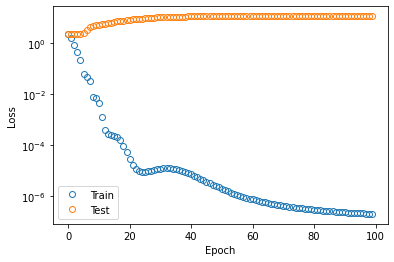

In [57]:
plt.plot(train_report.loss, 'o', mfc='None', label="Train")
plt.plot(test_report.loss, 'o', mfc='None', label="Test")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [41]:
plt.plot(train_report.entropy, 'o', mfc='None', label="Entropy")
plt.xlabel("Epoch")
plt.ylabel("Entropy")
plt.legend()
plt.show()

AttributeError: 'DataSet' object has no attribute 'entropy'

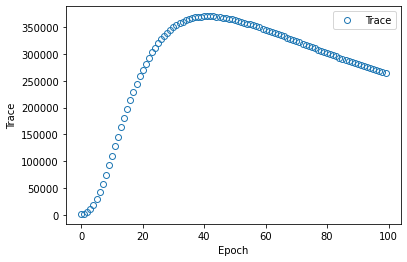

In [ ]:
plt.plot(train_report.trace, 'o', mfc='None', label="Trace")
plt.xlabel("Epoch")
plt.ylabel("Trace")
plt.legend()
plt.show()

# Perform quick study

In [99]:
data_generator = znnl.data.MNISTGenerator(ds_size=500)
data_generator.train_ds["inputs"] = data_generator.train_ds["inputs"][:50]
data_generator.train_ds["targets"] = data_generator.train_ds["targets"][:50]

In [111]:
class Network(nn.Module):
    """
    Simple CNN module.
    """
    @nn.compact
    def __call__(self, x):        
        x = x.reshape((x.shape[0], -1))  # flatten
        
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        return x

In [112]:
def perform_quick_study(trainer_module: SimpleTraining, trainer_kwargs: dict, key: int):


    model_key, trainer_key = jax.random.split(jax.random.PRNGKey(key), 2)
    model = znnl.models.FlaxModel(
        flax_module=Network(),
        optimizer=optax.adam(learning_rate=0.001),
        input_shape=(1, 28, 28, 1),
        seed=model_key[0], 
    )

    train_recorder = znnl.training_recording.JaxRecorder(
        name="train_recorder",
        loss=True,
        # ntk=True,
        # entropy= True, 
        # trace=True,
        # loss_derivative=True,
        update_rate=1, 
        chunk_size=1000
    )
    train_recorder.instantiate_recorder(
        data_set=data_generator.train_ds
    )


    test_recorder = znnl.training_recording.JaxRecorder(
        name="test_recorder",
        loss=True,
        update_rate=1,
        chunk_size=1000
    )
    test_recorder.instantiate_recorder(
        data_set=data_generator.test_ds
    )

    trainer = trainer_module(
        **trainer_kwargs,
        recorders=[train_recorder, test_recorder],  
        seed=trainer_key[0],
        model=model,
    )

    batched_training_metrics = trainer.train_model(
        train_ds=data_generator.train_ds, 
        test_ds=data_generator.test_ds,
        batch_size=32,
        epochs=200,
    )

    train_report = train_recorder.gather_recording()
    test_report = test_recorder.gather_recording()

    return train_report, test_report

In [119]:
simple_kwargs = {
    "loss_fn": znnl.loss_functions.CrossEntropyLoss(),
    "accuracy_fn": znnl.accuracy_functions.LabelAccuracy(), 
}

def get_blurred_kwargs(blurr_radius):
    blurred_training = {
        "loss_fn": znnl.loss_functions.CrossEntropyLoss(),
        "accuracy_fn": znnl.accuracy_functions.LabelAccuracy(), 
        "blurr_radius": blurr_radius, 
        "integral_numbers": 100,
    }
    return blurred_training


blurr_radia = [0.1, 0.08, 0.06, 0.04, 0.02]
trainers = [simple_kwargs] + [get_blurred_kwargs(rad) for rad in blurr_radia]

In [121]:
# Execute a quick study

train_report_simple, test_report_simple = perform_quick_study(SimpleTraining, trainers[0], 0)
train_report_blurred_1, test_report_blurred_1 = perform_quick_study(BlurredTraining, trainers[1], 0)
train_report_blurred_2, test_report_blurred_2 = perform_quick_study(BlurredTraining, trainers[2], 0)
train_report_blurred_3, test_report_blurred_3 = perform_quick_study(BlurredTraining, trainers[3], 0)
train_report_blurred_4, test_report_blurred_4 = perform_quick_study(BlurredTraining, trainers[4], 0)
train_report_blurred_5, test_report_blurred_5 = perform_quick_study(BlurredTraining, trainers[5], 0)



Epoch: 200: 100%|██████████████████████████████| 200/200 [00:26<00:00,  7.41batch/s, accuracy=0.692]


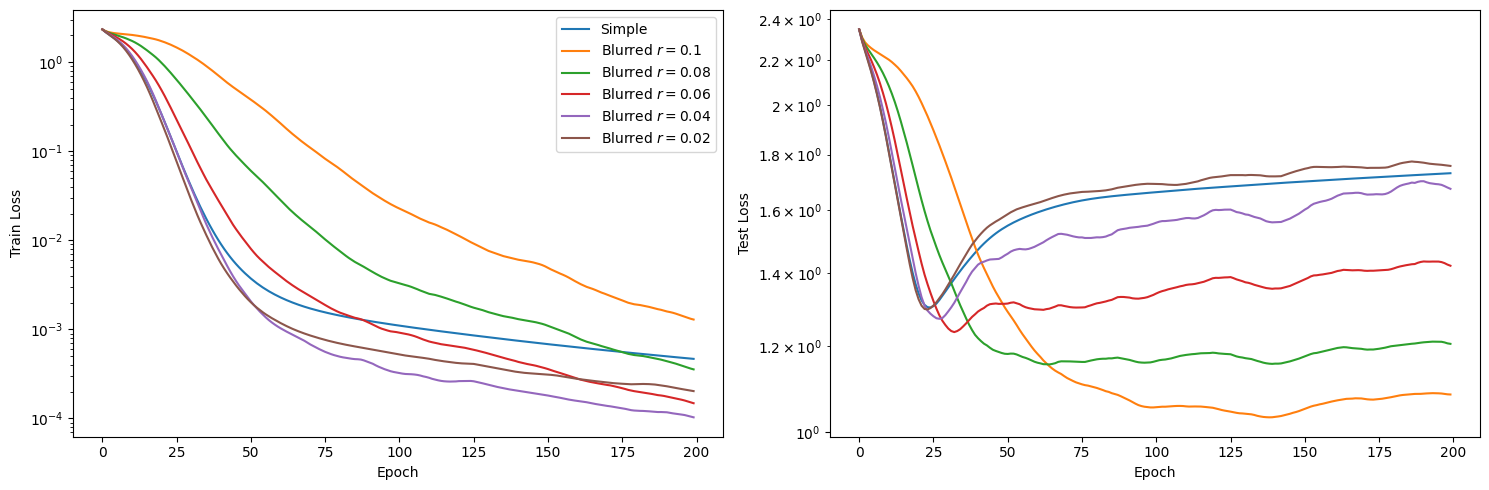

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

axs[0].plot(train_report_simple.loss, '-', label="Simple")
axs[0].plot(train_report_blurred_1.loss, '-', label=rf"Blurred $r = {blurr_radia[0]}$")
axs[0].plot(train_report_blurred_2.loss, '-', label=rf"Blurred $r = {blurr_radia[1]}$")
axs[0].plot(train_report_blurred_3.loss, '-', label=rf"Blurred $r = {blurr_radia[2]}$")
axs[0].plot(train_report_blurred_4.loss, '-', label=rf"Blurred $r = {blurr_radia[3]}$")
axs[0].plot(train_report_blurred_5.loss, '-', label=rf"Blurred $r = {blurr_radia[4]}$")

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Train Loss")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(test_report_simple.loss, '-', label="Simple")
axs[1].plot(test_report_blurred_1.loss, '-', label=rf"Blurred $r = {blurr_radia[0]}$")
axs[1].plot(test_report_blurred_2.loss, '-', label=rf"Blurred $r = {blurr_radia[1]}$")
axs[1].plot(test_report_blurred_3.loss, '-', label=rf"Blurred $r = {blurr_radia[2]}$")
axs[1].plot(test_report_blurred_4.loss, '-', label=rf"Blurred $r = {blurr_radia[3]}$")
axs[1].plot(test_report_blurred_5.loss, '-', label=rf"Blurred $r = {blurr_radia[4]}$")

axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Test Loss")
axs[1].set_yscale("log")

plt.show()
